<a href="https://colab.research.google.com/github/wolfinwallst/All-About-Financial-Data-Science/blob/main/LeNet_5_PyTorch_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lenet-5 PyTorch implementation**

[blog](https://juni5184.tistory.com/36) 참조함

설명은

[[1]](https://deep-learning-study.tistory.com/368?category=963091)

[[2]]()

In [1]:
from google.colab import drive
drive.mount('LeNet-5')

Drive already mounted at LeNet-5; to attempt to forcibly remount, call drive.mount("LeNet-5", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# 이런 파라미터들은 대문자로 쓰느게 convention인가?
random_seed = 42
learning_rate = 0.001
batch_size = 32
n_epochs = 15

img_size = 32
n_classes = 10

In [4]:
def get_accuracy(model, data_loader, device):
    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval() # eval 모드로 조정_학습시 필요한 dropout/batchnorm 비활성
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
    return correct_pred.float() / n

In [5]:
'''
loss plotting 함수
'''
def plot_loss(train_loss_list, valid_loss_list):
    # plt.style.use('seaborn') # <- colab에서 작동 안 함

    train_loss_list = np.array(train_loss_list)
    valid_loss_list = np.array(valid_loss_list)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(train_loss_list, color='blue', label='Training Loss')
    ax.plot(valid_loss_list, color='red', label='Validation Loss')
    ax.set(title='Loss over epochs',
           xlabel='Epoch',
           ylabel='Loss')
    ax.legend()
    fig.show()

    plt.style.use('default')

In [6]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for X, y_true in train_loader:
        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        y_pred, _ = model(X)
        loss = criterion(y_pred, y_true)
        running_loss += loss.item() * X.size(0)

        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [7]:
# validation에선 backprop 안 함
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        y_pred, _ = model(X)
        loss = criterion(y_pred, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [8]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    best_loss = 1e10
    train_loss_list = []
    valid_loss_list = []

    for epoch in range(0, epochs):
        # train
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_loss_list.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_loss_list.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_loss(train_loss_list, valid_loss_list)

    return model, optimizer, (train_loss_list, valid_loss_list)

In [9]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=False)

Text(0.5, 0.98, 'MNIST dataset - preview')

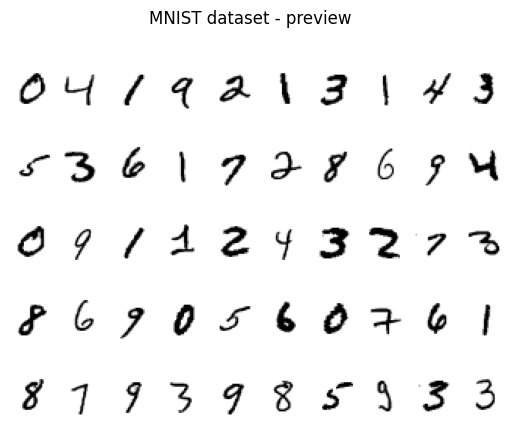

In [10]:
row_img = 10
n_rows = 5

fig = plt.figure()
for index in range(1, row_img * n_rows + 1):
    plt.subplot(n_rows, row_img, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')

fig.suptitle('MNIST dataset - preview')

각 층을 통과한 후 size는 이렇게 계산한다(직관적으로 당연함):

$${\text{output size}} = \frac{\text{input size} - \text{kernel size} + 2 \times \text{padding}}{\text{stride}} + 1$$

In [11]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        # input size = 1@32x32
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            # 6@28x28 feature map 6개
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # 6@14x14

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            # 16@10x10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # 16@5x5


            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            # 120@1x1
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [12]:
torch.manual_seed(random_seed)

model = LeNet5(n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

06:08:13 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
06:09:12 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
06:10:11 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
06:11:08 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
06:12:04 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.25	Valid accuracy: 98.75
06:13:02 --- Epoch: 5	Train loss: 0.0299	Valid loss: 0.0422	Train accuracy: 99.41	Valid accuracy: 98.66
06:14:02 --- Epoch: 6	Train loss: 0.0241	Valid loss: 0.0409	Train accuracy: 99.47	Valid accuracy: 98.70
06:14:59 --- Epoch: 7	Train loss: 0.0228	Valid loss: 0.0418	Train accuracy: 99.57	Valid accuracy: 98.69
06:15:58 --- Epoch: 8	Train loss: 0.0186	Valid loss: 0.0447	Train accuracy: 99.53	Valid accuracy: 98.70
06:16:55 --- Epoch: 9	Train loss: 0.0161	Valid loss: 0.0468	Trai

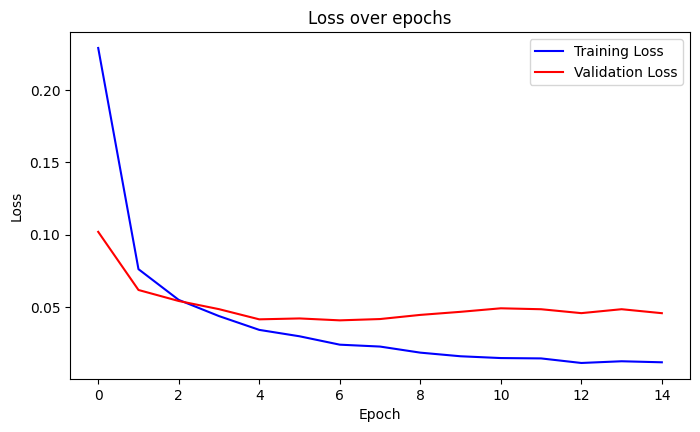

In [13]:
# 학습 진행
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader,
                                    valid_loader, n_epochs, device)